### Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. 


![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)



All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.





### The best I could do...

Together with Alberto Vecchio and Geraint Prattent, I tackled this classification problem with deep-learning: [arXiv:2007.06585](https://arxiv.org/abs/2007.06585). Next time we look into deep learning.

In the paper we reached an accuracy (true positive + true negative / total) of $98.4\%$. The data you're using are those of the green curve in Fig 2. Could you do better? If yes, please tell me how!

I should have really put a figure with my ROC in that paper but I didn't! Deep learning people liked the accuracy and I just went with the flow.


### Another idea

Here are other ideas that I haven't explored in a paper (yet?). 

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

Please let me know if you give it a try and what you find! 





------------
## My implementation

In [2]:
import numpy as np
import h5py
import deepdish
import matplotlib.pyplot as plt
import corner


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from astroML.utils import completeness_contamination
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

#plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15

color = ['#F5793A', '#A95AA1', '#85C0F9', '#0F2080']

In [3]:
'''function that assigns label 0 to the true positives, 
1 to the true negatives, 2 to the false negatives & 
3 to the false positives'''
def results(y_true, y_predicted):
    
    fn = np.logical_and(y_predicted != y_true, y_true == 1)
    tn = np.logical_and(y_predicted == y_true, y_true == 0)
    fp = np.logical_and(y_predicted != y_true, y_true == 0)
    
    label = np.zeros(len(y_true))  
    label[tn] = 1                     
    label[fn] = 2
    label[fp] = 3
    
    return label



def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    u = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    v = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    yy, xx = np.meshgrid(v, u)

    P = np.zeros_like(xx)
    for i, ui in enumerate(u):
        for j, vj in enumerate(v):
            Xgrid = np.array([ui, vj])
            P[i, j] = clf.decision_function(Xgrid.reshape(1,-1))
    return ax.contour(xx, yy, P, colors='k',
                      levels=[-1, 0, 1],
                      linestyles=['--', '-', '--'])


'''
centers and whitens data
'''
def whitendata(data):
    return (data-data.mean())/data.std()

In [4]:
data = deepdish.io.load('sample_2e7_design_precessing_higherordermodes_3detectors.h5')

In [5]:
data.keys()

dict_keys(['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z', 'N'])

In [6]:
ds = 20000   # downsize the sample

'''
X = np.zeros(len(data)-2)
features = np.zeros(len(data)-2)
for i, key in enumerate(list(data.keys())):
    print('ok1')
    print(i, key)
    if key !='det' and key !='snr':
        print('ok2')
        X[i] = data[key][:ds]
        print('ok3')
        features[i] = key
'''
        

X = np.array([data['mtot'][:ds], data['q'][:ds], data['chi1x'][:ds], 
              data['chi1y'][:ds], data['chi1z'][:ds], data['chi2x'][:ds],
              data['chi2y'][:ds], data['chi2z'][:ds], data['ra'][:ds], 
              data['dec'][:ds], data['iota'][:ds], data['psi'][:ds], 
            data['z'][:ds]]).T

y = data['det'][:ds]

features = ['mtot', 'q', 'chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y',
           'chi2z', 'ra', 'dec', 'iota', 'psi', 'z']

Let's give a quick look to data:

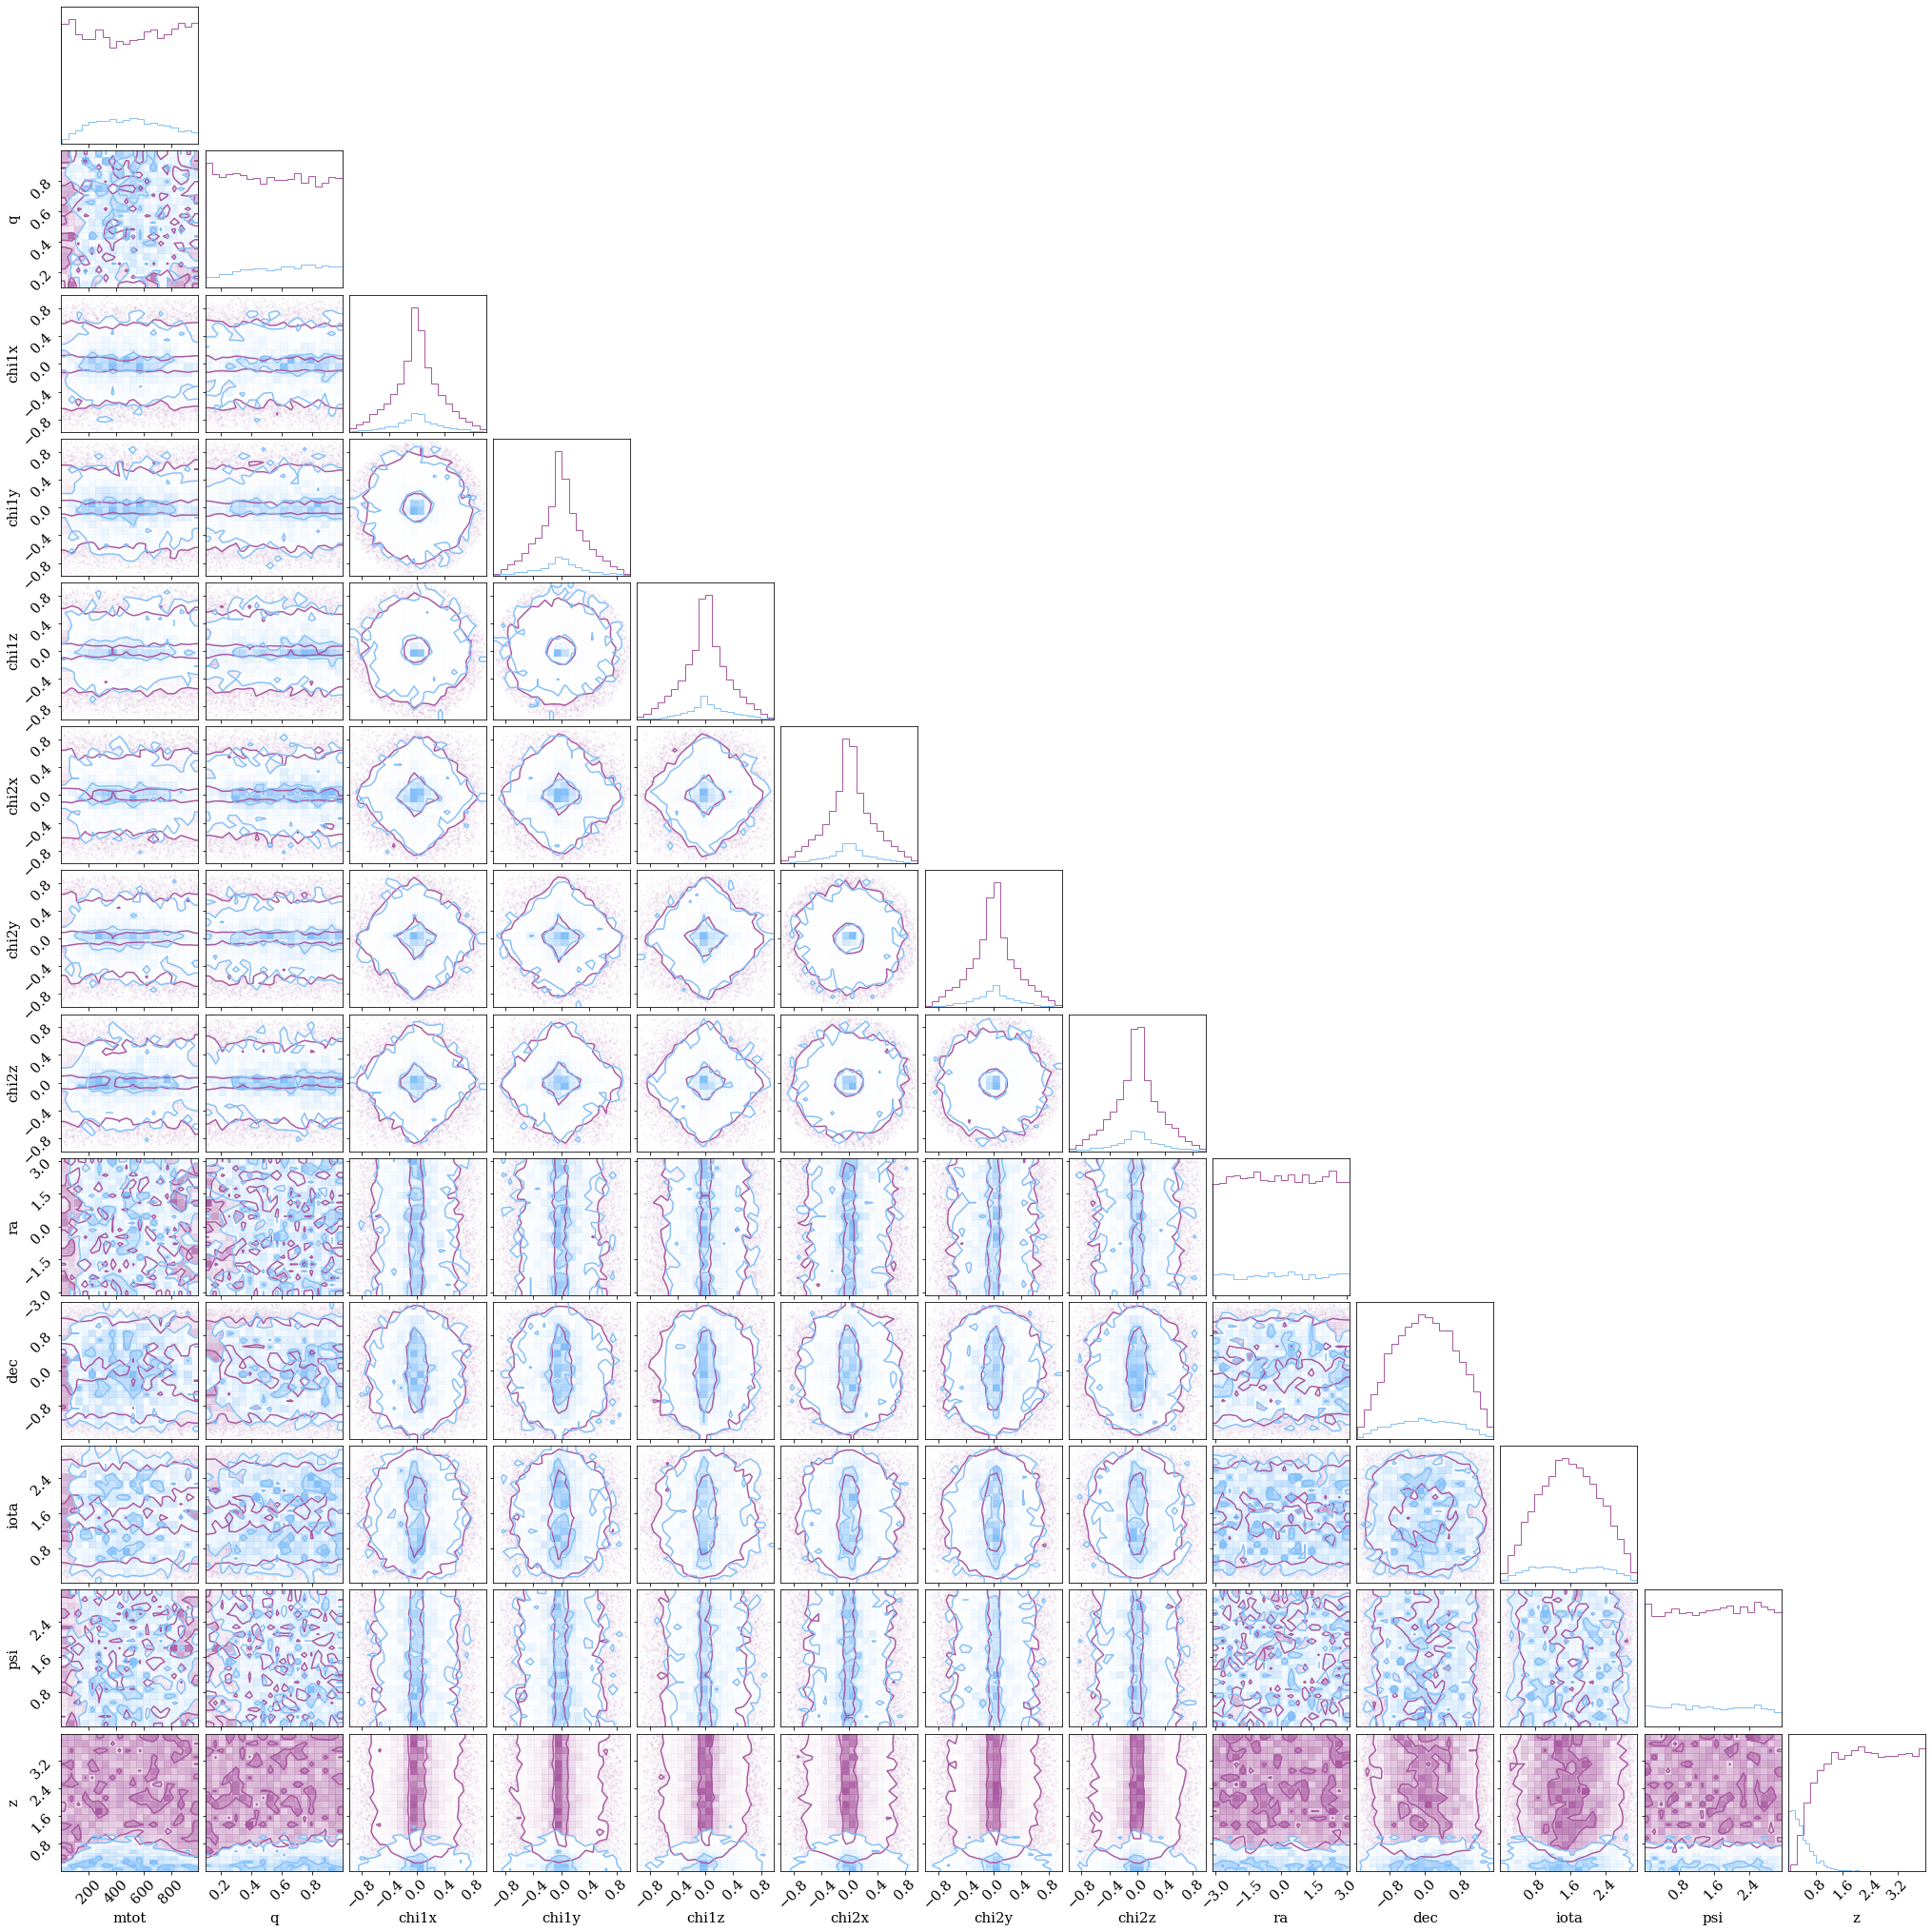

In [7]:
fig = corner.corner(X[y==0], labels=features, levels=[0.3, 0.9], color=color[1]);
corner.corner(X[y==1], labels=features, fig = fig, levels=[0.3, 0.9], color=color[2]);

##### PCA

In [10]:
# prepare data for PCA

'''
from tqdm import tqdm
Xpca = np.zeros(len(X.T))
for i in tqdm(range(len(X))):
    print(i, 'ok', X[i].shape, whitendata(X[i]).shape)
    Xpca[i] == whitendata(X[:,i])

'''

Xwhiten= np.array([whitendata(data['mtot'][:ds]), whitendata(data['q'][:ds]), whitendata(data['chi1x'][:ds]), 
                      whitendata(data['chi1y'][:ds]), whitendata(data['chi1z'][:ds]),
                      whitendata(data['chi2x'][:ds]), whitendata(data['chi2y'][:ds]),
                      whitendata(data['chi2z'][:ds]), whitendata(data['ra'][:ds]), 
                      whitendata(data['dec'][:ds]), whitendata(data['iota'][:ds]), 
                      whitendata(data['psi'][:ds]), whitendata(data['z'][:ds])
                     ]).T

Xwhiten[0,:].shape

(13,)

How many components should I keep?

How many components contain the 90% variance: (array([11, 12]),)


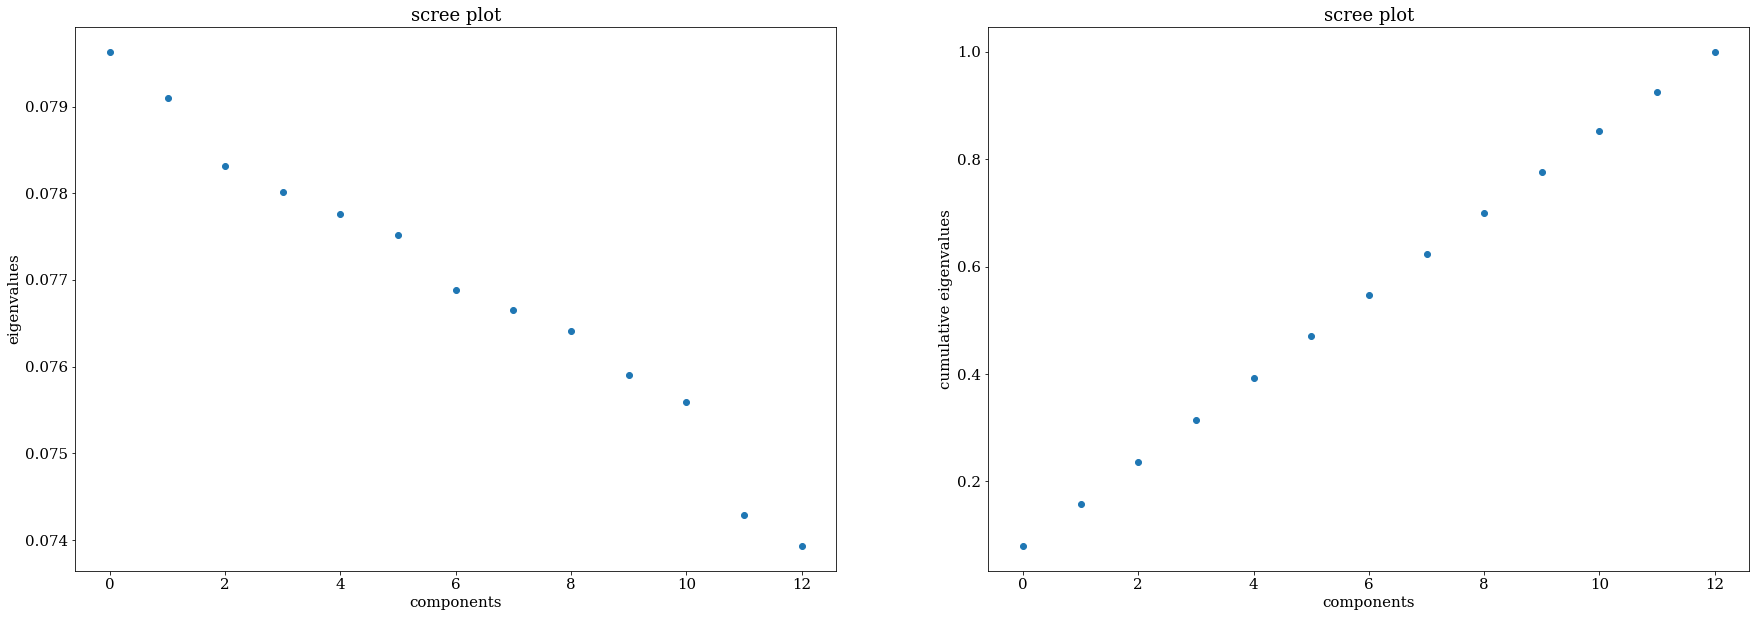

In [9]:
pca=PCA()
pca.fit(Xwhiten)
var = pca.explained_variance_ratio_

fig = plt.figure(figsize=(30,10))

ax1 = fig.add_subplot(121)
plt.scatter(np.arange(0, len(Xwhiten[0,:])), var)
plt.ylabel('eigenvalues')
plt.xlabel('components')
plt.title('scree plot');

ax2 = fig.add_subplot(122)
plt.scatter(np.arange(0, len(Xwhiten[0,:])), np.cumsum(var))
plt.ylabel('cumulative eigenvalues')
plt.xlabel('components')
plt.title('scree plot')

print('How many components contain the 90% variance:', np.where(np.cumsum(var) > 0.9));

I thus selct only the features that seem interesting (mtot, q, iota, z):

In [11]:
X = np.array([data['mtot'][:ds], data['q'][:ds], data['iota'][:ds], data['z'][:ds]]).T
Xcleaned = np.array([whitendata(data['mtot'])[:ds], whitendata(data['q'])[:ds],
                     whitendata(data['iota'])[:ds], whitendata(data['z'])[:ds]]).T

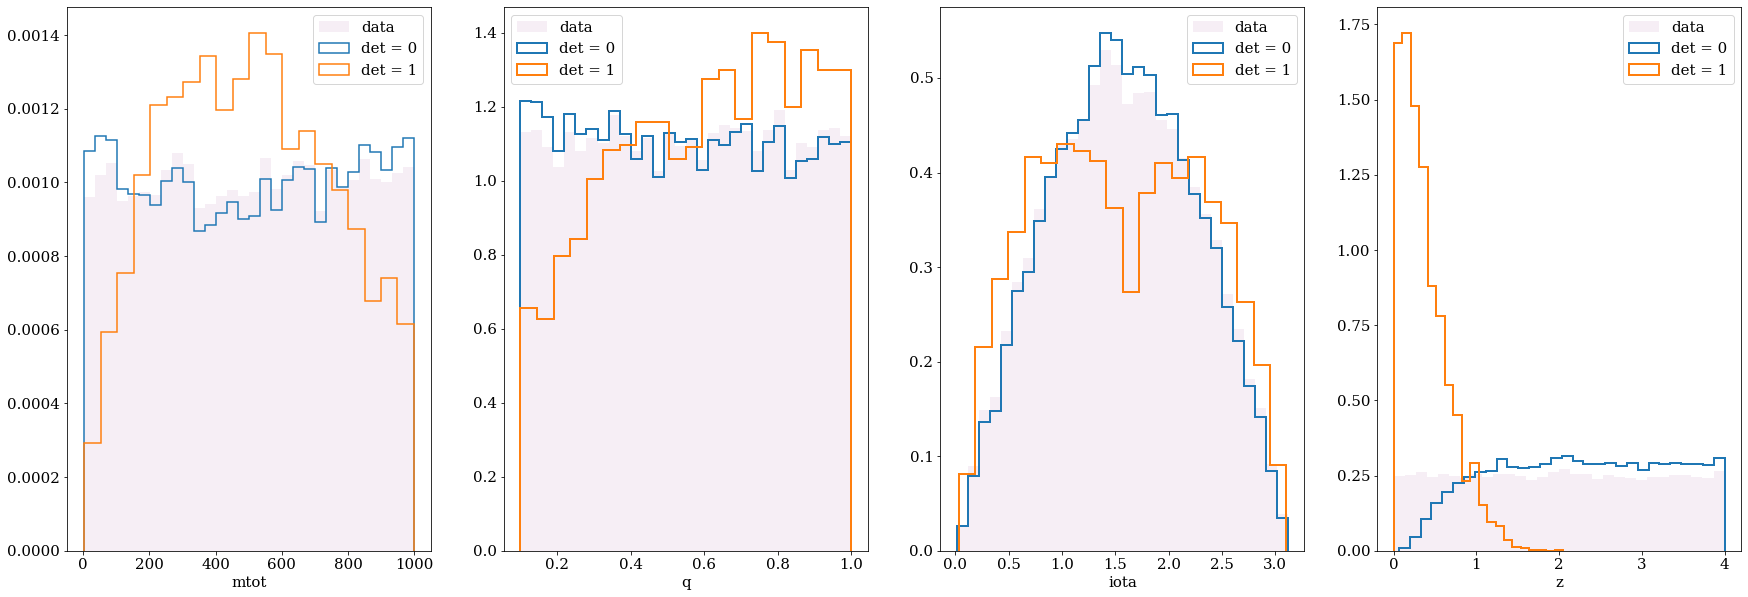

In [12]:
fig = plt.figure(figsize=(30,10))

ax1 = fig.add_subplot(141)
plt.hist(X[:,0][:ds], bins=30, alpha=0.1, color=color[1], label='data', density=True)
plt.hist(X[:,0][:ds][y == 0], bins=30, histtype='step', label='det = 0', lw=1.5, density=True)
plt.hist(X[:,0][:ds][y == 1], bins=20, histtype='step', label='det = 1', lw=1.5, density=True)
ax1.set_xlabel('mtot')
ax1.legend()

ax2 = fig.add_subplot(142)
plt.hist(X[:,1][:ds], bins=30, alpha=0.1, color=color[1], label='data', density=True)
plt.hist(X[:,1][:ds][y == 0], bins=30, histtype='step', label='det = 0', lw=2, density=True)
plt.hist(X[:,1][:ds][y == 1], bins=20, histtype='step', label='det = 1', lw=2, density=True)
ax2.set_xlabel('q')
ax2.legend(loc = 'upper left')

ax3 = fig.add_subplot(143)
plt.hist(X[:,2][:ds], bins=30, alpha=0.1, color=color[1], label='data', density=True)
plt.hist(X[:,2][:ds][y == 0], bins=30, histtype='step', label='det = 0', lw=2, density=True)
plt.hist(X[:,2][:ds][y == 1], bins=20, histtype='step', label='det = 1', lw=2, density=True)
ax3.set_xlabel('iota')
ax3.legend()

ax4 = fig.add_subplot(144)
plt.hist(X[:,3][:ds], bins=30, alpha=0.1, color=color[1], label='data', density=True)
plt.hist(X[:,3][:ds][y == 0], bins=30, histtype='step', label='det = 0', lw=2, density=True)
plt.hist(X[:,3][:ds][y == 1], bins=20, histtype='step', label='det = 1', lw=2, density=True)
ax4.set_xlabel('z')
ax4.legend()

### Decision trees

In [46]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

X1train, X1test, y1train, y1test = train_test_split(Xcleaned, y, test_size=0.3, random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(14000, 4) (6000, 4) (14000,) (6000,)
(14000, 4) (6000, 4) (14000,) (6000,)


##### Optimization with GridSearchCV

In [14]:
# cv
dt= DecisionTreeClassifier(random_state=8)

par = {'criterion' : ['entropy','gini'], 
       'max_depth' : np.arange(1,20)}

grid = GridSearchCV(dt, param_grid=par, cv=10)
grid.fit(Xtrain, ytrain)
best_criterion = grid.best_params_['criterion']
best_depth = grid.best_params_['max_depth']
print('best criterion', best_criterion);
print('maximumm depth:', best_depth)

best criterion entropy
maximumm depth: 8


Performance on the test set:

In [15]:
dt = DecisionTreeClassifier(random_state=8, criterion=best_criterion, max_depth=best_depth)
dt.fit(Xtrain, ytrain)
ypred = dt.predict(Xtest)
completeness, contamination = completeness_contamination(ypred,ytest)

print('\n accuracy:', accuracy_score(ytest, ypred))
print('\n confusion matrix: \n', confusion_matrix(ytest, ypred))
print('\n completeness, contamination:', completeness, contamination)


 accuracy: 0.9538333333333333

 confusion matrix: 
 [[4983  143]
 [ 134  740]]

 completeness, contamination: 0.8466819221967964 0.16194790486976218


### Random forest

In [16]:
# cv
rf = RandomForestClassifier(100)
par = {'max_depth' : np.arange(1,20)}

grid = GridSearchCV(rf, param_grid=par, cv=10, n_jobs=-1)
grid.fit(Xtrain, ytrain)
best_depth = grid.best_params_['max_depth']
print('maximumm depth:', best_depth)

maximumm depth: 10


In [17]:
# performance
rf =RandomForestClassifier(100, criterion='entropy', max_depth=best_depth, random_state=8)
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)
completeness, contamination = completeness_contamination(ypred, ytest)

print('\n accuracy:', accuracy_score(ytest, ypred))
print('\n confusion matrix: \n', confusion_matrix(ytest, ypred))
print('\n completeness, contamination:', completeness, contamination)


 accuracy: 0.9616666666666667

 confusion matrix: 
 [[5014  112]
 [ 118  756]]

 completeness, contamination: 0.8649885583524027 0.12903225806451613


### Neural network

In [386]:
'''
# cv
NN = MLPClassifier(activation='relu', solver='adam', max_iter=1000, random_state=6)

par={'hidden_layer_sizes': np.linspace(1,10,10, dtype='int'), 
    'learning_rate_init': np.linspace(0.001,0.1,10)}

grid = GridSearchCV(NN, param_grid=par, cv=5, n_jobs=-1) 

# fit
grid.fit(X1train, y1train)

# results
best_lr = grid.best_params_['learning_rate_init']
best_hls = grid.best_params_['hidden_layer_sizes'] 
print('best learning rate:', best_lr, 
      '\n best hidden layers size:',best_hls)
'''

best learning rate: 0.034 
 best hidden layers size: 8


##### optimization with GridSearch

In [430]:
# cv
NN = MLPClassifier(activation='relu', solver='adam', max_iter=1000, random_state=6)

# hidden layers from 1 to 3 all with the same number of neaurons, that goes from 1 to 11
HL = np.array([[b, np.full((2), b), np.full((3), b)] for b in range(1,11)])
print(HL)
HL = HL.flatten()

par={'hidden_layer_sizes': HL, 
    'learning_rate_init': np.linspace(0.001,0.01,10)}

grid = GridSearchCV(NN, param_grid=par, cv=5, n_jobs=-1) 

# fit
grid.fit(X1train, y1train)

# results
best_lr = grid.best_params_['learning_rate_init']
best_hls = grid.best_params_['hidden_layer_sizes'] 
print('best learning rate:', best_lr, 
      '\n best hidden layers size:',best_hls)

[[1 array([1, 1]) array([1, 1, 1])]
 [2 array([2, 2]) array([2, 2, 2])]
 [3 array([3, 3]) array([3, 3, 3])]
 [4 array([4, 4]) array([4, 4, 4])]
 [5 array([5, 5]) array([5, 5, 5])]
 [6 array([6, 6]) array([6, 6, 6])]
 [7 array([7, 7]) array([7, 7, 7])]
 [8 array([8, 8]) array([8, 8, 8])]
 [9 array([9, 9]) array([9, 9, 9])]
 [10 array([10, 10]) array([10, 10, 10])]]


/var/folders/l6/xx2lbds11l37fqdhf3bcglx80000gn/T/ipykernel_2546/1902648947.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  HL = np.array([[b, np.full((2), b), np.full((3), b)] for b in range(1,11)])


best learning rate: 0.002 
 best hidden layers size: [9 9 9]


In [48]:
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(NN, param_distributions=par, cv=10, n_jobs=-1) 
search.fit(X1train, y1train)

# results
best_lr = search.best_params_['learning_rate_init']
best_hls = search.best_params_['hidden_layer_sizes']

In [52]:
# performance
# from gridsearch cv:

best_hls = [9, 9, 9]
best_lr = 0.002 

NN = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes = best_hls,
                   learning_rate_init = best_lr, random_state=6)

NN.fit(Xtrain, ytrain)
ypred = NN.predict(Xtest)
completeness, contamination = completeness_contamination(ypred, ytest)

print('\n accuracy:', accuracy_score(ytest, ypred))
print('\n confusion matrix: \n', confusion_matrix(ytest, ypred))
print('\n completeness, contamination:', completeness, contamination)


 accuracy: 0.9446666666666667

 confusion matrix: 
 [[4982  144]
 [ 188  686]]

 completeness, contamination: 0.7848970251716247 0.17349397590361446


#### Most important features

Let's see the feature combination that allows to improve the performance for the three algorithms.

1. Take a dataset with two features where the first one is z and the second one changes each time. Train the classifier and use a test set to get the accuracy. The feature that allows higher accuracy is finally append to the dataset.
Save the higher accuracy result.

2. Repeat the process until the dataset as all the features ordered according to the combinations that allows maximum accuracy

3. See how accuracy changes while adding features. Truncate the dataset at the feature that allows maximum accuracy.

In [432]:
def important_features(clf):
    x = np.zeros((len(X), 13)) 
    features = ['mtot', 'q', 'chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y',
               'chi2z', 'ra', 'dec', 'iota', 'psi', 'z']
    tot_accuracy = []
    tot_completeness =[]
    tot_contamination =[]
    important_f = []   
    

    # add z feature to x and remove it from features
    x[:,0] = data['z'][:ds]
    features = features[:-1]   
    important_f.append('z')

    # get recursively the next best (in terms of accuracy) feature to add:
    for i in range(2, 14):
        xtry = x[:, :i]      # make an array with the previously chosen best features and an additional zero column
        accuracy = []
        completeness = []
        contamination = []
    
        # plug in the zero column a new feature, do the classification abd store the accuracy
        for f in features:   
            xtry[:, i-1] =  data[f][:ds]
            xtrain, xtest, ytrain, ytest = train_test_split(xtry, y, test_size=0.3, random_state=42)
            clf.fit(xtrain, ytrain)
            ypred = clf.predict(xtest)
            accuracy.append(accuracy_score(ytest, ypred))
            comp, cont = completeness_contamination(ypred, ytest)
            completeness.append(comp)
            contamination.append(cont)

        # choose the feature that gives the best accuracy 
        #print(accuracy)
        index_best_feature = int(np.where(accuracy == max(accuracy))[0][0])   
        best_feature = features[index_best_feature]
        important_f.append(best_feature)
        #print('important feature:', best_feature)
    
    
        # add the best feature in the x vector and remove it from features vector
        x[:,i-1] = data[best_feature][:ds]
        features.remove(best_feature)
    
        # save the accuracy of that combination in a vector 
        tot_accuracy.append(max(accuracy))
        tot_completeness.append(completeness[index_best_feature])
        tot_contamination.append(contamination[index_best_feature])
        
    return x, important_f, tot_accuracy, tot_completeness, tot_contamination



################################## same but with cleaned data ########################


def important_featuresNN(clf):
    x = np.zeros((len(X), 13)) 
    features = ['mtot', 'q', 'chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y',
               'chi2z', 'ra', 'dec', 'iota', 'psi', 'z']
    tot_accuracy = []
    tot_completeness =[]
    tot_contamination =[]
    important_f = []   
    

    # add z feature to x and remove it from features
    x[:,0] = whitendata(data['z'][:ds])
    features = features[:-1]   
    important_f.append('z')

    # get recursively the next best (in terms of accuracy) feature to add:
    for i in range(2, 14):
        xtry = x[:, :i]      # make an array with the previously chosen best features and an additional zero column
        accuracy = []
        completeness = []
        contamination = []
    
        # plug in the zero column a new feature, do the classification abd store the accuracy
        for f in features:   
            xtry[:, i-1] =  whitendata(data[f][:ds])
            xtrain, xtest, ytrain, ytest = train_test_split(xtry, y, test_size=0.3, random_state=42)
            clf.fit(xtrain, ytrain)
            ypred = clf.predict(xtest)
            accuracy.append(accuracy_score(ytest, ypred))
            comp, cont = completeness_contamination(ypred, ytest)
            completeness.append(comp)
            contamination.append(cont)

        # choose the feature that gives the best accuracy 
        #print(accuracy)
        index_best_feature = int(np.where(accuracy == max(accuracy))[0][0])   
        best_feature = features[index_best_feature]
        important_f.append(best_feature)
        #print('important feature:', best_feature)
    
    
        # add the best feature in the x vector and remove it from features vector
        x[:,i-1] = whitendata(data[best_feature][:ds])
        features.remove(best_feature)
    
        # save the accuracy of that combination in a vector 
        tot_accuracy.append(max(accuracy))
        tot_completeness.append(completeness[index_best_feature])
        tot_contamination.append(contamination[index_best_feature])
        
    return x, important_f, tot_accuracy, tot_completeness, tot_contamination

In [433]:
Xnn, featuresnn, accuracynn, completenessnn, contaminationnn = important_featuresNN(NN)

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [340]:
# most important features for the classifiers:
Xdt, featuresdt, accuracydt, completenessdt, contaminationdt = important_features(dt)
Xrf, featuresrf, accuracyrf, completenessrf, contaminationrf = important_features(rf)
Xnn, featuresnn, accuracynn, completenessnn, contaminationnn = important_featuresNN(NN)

order of features for decision tree: 
 ['z', 'mtot', 'iota', 'q', 'psi', 'ra', 'chi1x', 'chi2y', 'chi2x', 'chi1y', 'chi1z', 'dec', 'chi2z']
order of features for random forest: 
 ['z', 'mtot', 'iota', 'q', 'chi1z', 'chi2z', 'psi', 'chi1y', 'chi2y', 'chi2x', 'ra', 'dec', 'chi1x']
order of features for neural network: 
 ['z', 'mtot', 'iota', 'q', 'chi1z', 'chi2z', 'psi', 'chi1y', 'chi2y', 'chi2x', 'ra', 'dec', 'chi1x']


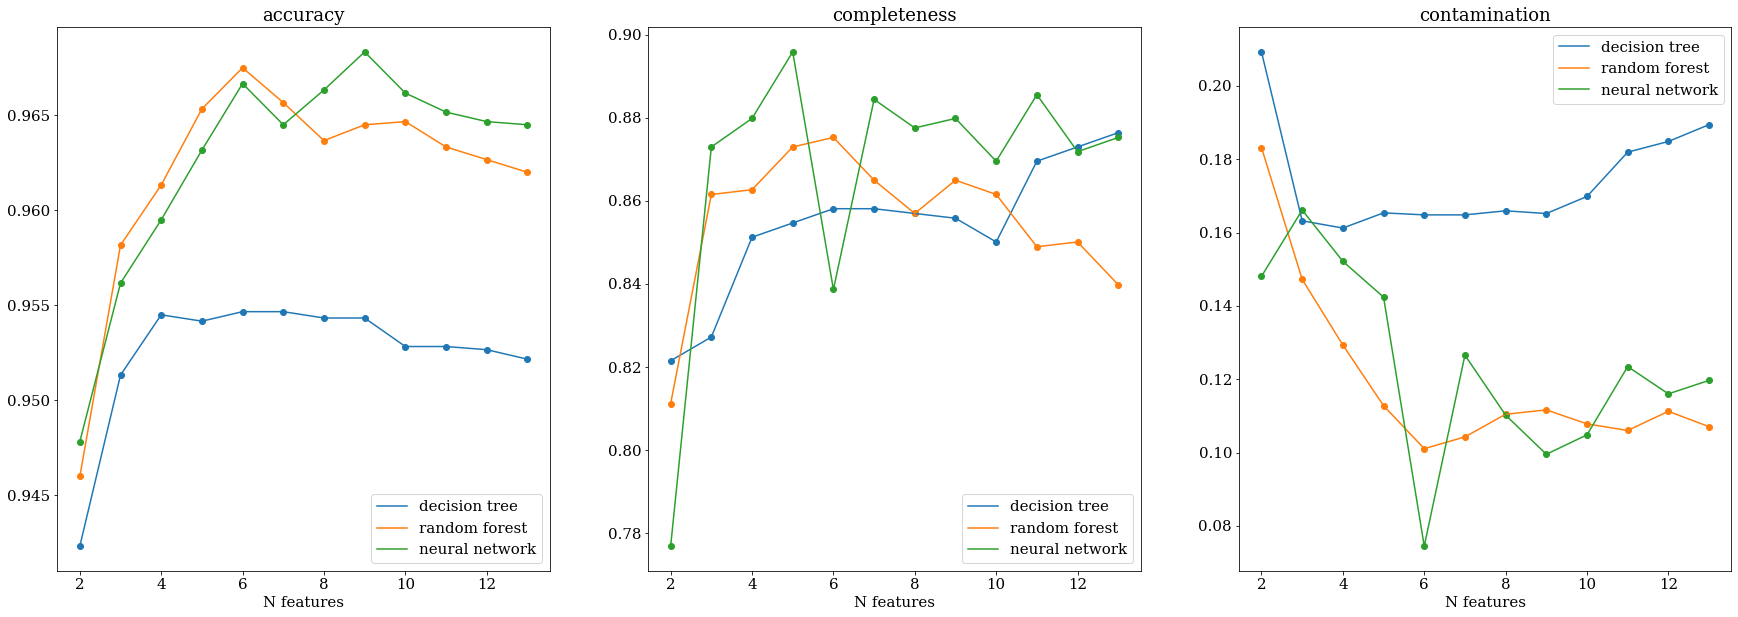

In [434]:
# plot the accuracy results
fig = plt.figure(figsize=(30,10))

ax1 = fig.add_subplot(131)  

plt.scatter(np.arange(2,14), accuracydt)
plt.plot(np.arange(2,14), accuracydt, label='decision tree')
plt.scatter(np.arange(2,14), accuracyrf)
plt.plot(np.arange(2,14), accuracyrf, label='random forest')
plt.scatter(np.arange(2,14), accuracynn)
plt.plot(np.arange(2,14), accuracynn, label='neural network')

plt.xlabel('N features')
plt.title('accuracy')
plt.legend()

ax2 = fig.add_subplot(132)  

plt.scatter(np.arange(2,14), completenessdt)
plt.plot(np.arange(2,14), completenessdt, label='decision tree')
plt.scatter(np.arange(2,14), completenessrf)
plt.plot(np.arange(2,14), completenessrf, label='random forest')
plt.scatter(np.arange(2,14), completenessnn)
plt.plot(np.arange(2,14), completenessnn, label='neural network')

plt.xlabel('N features')
plt.title('completeness')
plt.legend()

ax3 = fig.add_subplot(133)  

plt.scatter(np.arange(2,14), contaminationdt)
plt.plot(np.arange(2,14), contaminationdt, label='decision tree')
plt.scatter(np.arange(2,14), contaminationrf)
plt.plot(np.arange(2,14), contaminationrf, label='random forest')
plt.scatter(np.arange(2,14), contaminationnn)
plt.plot(np.arange(2,14), contaminationnn, label='neural network')

plt.xlabel('N features')
plt.title('contamination')
#plt.title('Decision tree')
plt.legend()

print('order of features for decision tree: \n', featuresdt)
print('order of features for random forest: \n', featuresrf)
print('order of features for neural network: \n', featuresrf);

In [435]:
print('                   max accuracy       max completeness     min contamination \n'
      '\n decision tree:  ', np.where(accuracydt == max(accuracydt)), '  ',
      np.where(completenessdt == max(completenessdt)), '     ',
      np.where(contaminationdt == min(contaminationdt)),
      '\n random forest:   ', np.where(accuracyrf == max(accuracyrf)), '    ',
      np.where(completenessrf == max(completenessrf)), '      ',
      np.where(contaminationrf == min(contaminationrf)),
      '\n neural network:   ', np.where(accuracynn == max(accuracynn)), '    ',
      np.where(completenessnn == max(completenessnn)), '      ',
      np.where(contaminationnn == min(contaminationnn)),
     )

                   max accuracy       max completeness     min contamination 

 decision tree:   (array([4, 5]),)    (array([11]),)       (array([2]),) 
 random forest:    (array([4]),)      (array([4]),)        (array([4]),) 
 neural network:    (array([7]),)      (array([3]),)        (array([4]),)


In [459]:
print('                   max accuracy         max completeness     min contamination \n'
      '\n decision tree:  ', accuracydt[4], '  ', completenessdt[4], '     ', contaminationdt[4],
      '\n random forest:  ', accuracyrf[4], '              ', completenessrf[4], '     ', contaminationrf[4],
      '\n neural network: ', accuracynn[7], '  ', completenessnn[7], '      ', contaminationnn[7])

                   max accuracy         max completeness     min contamination 

 decision tree:   0.9546666666666667    0.8581235697940504       0.16481069042316257 
 random forest:   0.9675                0.8752860411899314       0.10105757931844889 
 neural network:  0.9683333333333334    0.879862700228833        0.09953161592505855
